# 等离子体电子声不稳定性：Two-kappa Electrons Model

In [2]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy.mathematics
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

## 模型
### 1D等离子体：双kappa运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left( f_s + f_f  \right) (1+d \cos kx) $$
$$ f_s = \frac{n_s}{\sqrt{2\pi \kappa_s v_s^2}} \frac{\Gamma(\kappa_s)}{\Gamma(\kappa_s-1/2)} \left( 1+\frac{v^2}{\kappa_s v_s^2} \right)^{-\kappa_s} $$
$$ f_f = \frac{n_f}{\sqrt{2\pi \kappa_f v_f^2}} \frac{\Gamma(\kappa_f)}{\Gamma(\kappa_f-1/2)} \left( 1+\frac{v^2}{\kappa_f v_f^2} \right)^{-\kappa_f} $$
$$ f_f(\kappa \rightarrow \infty) = \frac{n_f}{\sqrt{2\pi v_f^2}} \exp \left[ -\frac{(v-u_f)^2}{v_f^2}\right]$$
                          
- 色散关系
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 - \frac{1}{2 \kappa_f} +\xi_f Z_{\kappa_f}(\xi_f) \right] = 0 $$
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 + \xi_f Z(\xi_f) \right] = 0 $$
其中$\xi_\sigma = \frac{\omega/k-u_\sigma}{\theta_\sigma}$，$\theta_\sigma = \sqrt{\frac{2\kappa_\sigma-3}{\kappa_\sigma} \frac{T}{m}}$，
$$ Z_{\kappa_\sigma}(\xi) = \frac{\Gamma(\kappa_\sigma+1)}{\sqrt{\pi}\kappa_\sigma^{3/2} \Gamma(\kappa_\sigma-1/2)} \int_{-\infty}^{+\infty} \frac{(1+s^2/\kappa_\sigma)^{-\kappa_\sigma-1}}{s-\xi} ds$$
上述色散关系将允许两支波，一支类似于fast electrons的Langmuir波（LW）；另一支类似于slow electrons的Acoustic波（KW，由两组分不同$\kappa$导致）

- 让KW展现出来的关键在于
    - 排除热电子LW，$\gamma_{KW} < \gamma_{LW}^{hot}$
    - KW本身不能过阻尼，$\gamma_{KW} \le \omega_r/(2\pi)$，满足此条件可获得存在较长时间的KW

## 数值理论分析

In [24]:
def fk(v):
    r_s = ( 1 + (v/v_s)**2/kappa_s)**(-kappa_s)
    r_f = ( 1 + (v/v_f)**2/kappa_f)**(-kappa_f)
    A_s = n_s/np.sqrt(2*np.pi*kappa_s)/v_s * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(2*np.pi*kappa_f)/v_f * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    
    return A_s*r_s+A_f*r_f

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
#     kappa_f=100
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_f**2 * ( 1 + zeta_f*plasmapy.mathematics.plasma_dispersion_func(zeta_f) )
#     r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + (kappa_f/(kappa_f-1.5)) / k**2 / l_f**2 * ( 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f) )
    return [r.real,r.imag]

def PDR_1KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) )
    return [r.real,r.imag]

import quadpy

def dispersion_function(zeta,kappa):
    r = 0.0
    A_kappa = (kappa)**(-1.5) * sp.gamma(kappa+1) / sp.gamma(kappa-0.5)
    def integrand(xi):
        return  (1+xi**2/kappa)**(-kappa-1)
    if zeta.imag>0:
        r = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,np.inf)[0]
    elif zeta.imag==0:
        x = 0.1
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1 = (1/np.sqrt(np.pi)) * integrate.quad(integrand,s_n,s_p, weight='cauchy',wvar=zeta.real)[0]
        real2 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = real + 1j*imag
    elif zeta.imag<0:
        x = 1e-8
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1a = -1j * quadpy.quad(lambda xi_i: integrand(s_n+1j*xi_i)/(1j*xi_i-1j*zeta.imag-x),zeta.imag,0)[0]
        real1b =  1j * quadpy.quad(lambda xi_i: integrand(s_p+1j*xi_i)/(1j*xi_i-1j*zeta.imag+x),zeta.imag,0)[0]
        real2 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1a+real1b+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = (1/np.sqrt(np.pi)) * real + 1j*imag
    return r * A_kappa

def PrintParas():
    paras_table = PrettyTable(['-','n','kappa','wp','theta','lambda_D','T'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4),round(T_s,4)])
    paras_table.add_row(['f',n_f,'inf',round(wp_f,4),round(v_f,4),round(l_f,4),round(T_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    T_s = kappa_s/(2*kappa_s-3)*m*v_s**2
#     T_f = kappa_f/(2*kappa_f-3)*m*v_f**2
    T_f = 0.5*m*v_f**2
    l_s = np.sqrt( T_s / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T_f / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    return n_f,l_s,l_f,wp_s,wp_f,T_s,T_f

### PDR中的KW分支和LW分支

In [118]:
# 等离子体基本参数
n = 1
q = 1
m = 1
v_s = 1
v_f = v_s

n_s = 0.7
kappa_s = 1.501

n_f,l_s,l_f,wp_s,wp_f,T_s,T_f=SetParas()
u_s = 0
u_f = 0
PrintParas()

+---+---------------------+-------+--------+-------+----------+-------+
| - |          n          | kappa |   wp   | theta | lambda_D |   T   |
+---+---------------------+-------+--------+-------+----------+-------+
| s |         0.7         | 1.501 | 0.8367 |   1   | 32.7436  | 750.5 |
| f | 0.30000000000000004 |  inf  | 0.5477 |   1   |  1.291   |  0.5  |
+---+---------------------+-------+--------+-------+----------+-------+


In [119]:
wr_kw_guess = 0.236
wi_kw_guess = -0.127
wr_lw_guess = 1.019
wi_lw_guess = -0.015

In [120]:
# 搜索a=0时解方程初值
s0=op.root(lambda w:PDR_2KE(w,0.1),[wr_kw_guess,wi_kw_guess],method='hybr')
s1=op.root(lambda w:PDR_2KE(w,0.1),[wr_lw_guess,wi_lw_guess],method='hybr')
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
wr_kw_guess = s0.x[0]
wi_kw_guess = s0.x[1]
wr_lw_guess = s1.x[0]
wi_lw_guess = s1.x[1]
wr_kw_guess_int = s0.x[0]
wi_kw_guess_int = s0.x[1]
wr_lw_guess_int = s1.x[0]
wi_lw_guess_int = s1.x[1]

k =  0.1
True [ 0.22370925 -0.13436465]
True [ 1.02438113 -0.02150096]


- 计算LW和EAW的$\omega$和$\gamma$

In [121]:
k_list = np.linspace(0.1,1.5,num=100)

wr_kw_guess = wr_kw_guess_int
wi_kw_guess = wi_kw_guess_int
wr_lw_guess = wr_lw_guess_int
wi_lw_guess = wi_lw_guess_int

wr_kw_list = []
wi_kw_list = []
wr_lw_list = []
wi_lw_list = []

for k_each in tqdm(k_list,position=0,leave=True):
    s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw_guess = s_kw.x[0]
        wi_kw_guess = s_kw.x[1]
        wr_kw_list.append(s_kw.x[0])
        wi_kw_list.append(s_kw.x[1])
    else:
#         print("kw, error for k=",k_each)
        wr_kw_list.append(np.nan)
        wi_kw_list.append(np.nan)
    s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess],method='hybr')
    if s_lw.success==True:
        wr_lw_guess = s_lw.x[0]
        wi_lw_guess = s_lw.x[1] 
        wr_lw_list.append(s_lw.x[0])
        wi_lw_list.append(s_lw.x[1])
    else:
#         print("lw, error for k=",k_each)
        wr_lw_list.append(np.nan)
        wi_lw_list.append(np.nan)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]


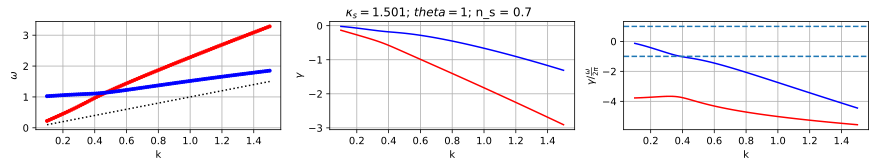

In [122]:
fig = plt.figure(figsize=(15,2))

ax1 = plt.subplot(131)
ax1.plot(k_list,wr_kw_list,'.',color='red')
ax1.plot(k_list,wr_lw_list,'.',color='blue')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega$')
ax1.plot(k_list,k_list*v_s,color='black',ls=':')
# ax1.plot(k_list,k_list*v_f,color='green',ls=':')
ax1.grid()

ax2 = plt.subplot(132)
ax2.plot(k_list,wi_kw_list,color='red')
ax2.plot(k_list,wi_lw_list,color='blue')
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()

b_kw = np.array(wi_kw_list)/abs(np.array(wr_kw_list)/2/np.pi)
b_lw = np.array(wi_lw_list)/abs(np.array(wr_lw_list)/2/np.pi)
ax3 = plt.subplot(133)
ax3.plot(k_list,b_kw,color='red')
ax3.plot(k_list,b_lw,color='blue')
ax3.axhline(-1,linestyle='--')
ax3.axhline(1,linestyle='--')
ax3.set_xlabel('k')
ax3.set_ylabel(r'$\gamma/\frac{\omega}{2\pi}$')
ax3.grid()
plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $theta = $"+str(v_s)+"; n_s = "+str(n_s))
plt.show()

#### $r_{max}(n_s,\kappa_s)$图

In [126]:
kappa_s_list = np.linspace(1.501,1.52,num=10)
n_s_list = np.linspace(0.1,0.8,num=8)

In [127]:
n_s=n_s_list[0]
kappa_s = kappa_s_list[0]
n_f,l_s,l_f,wp_s,wp_f,T_s,T_f=SetParas()
PrintParas()
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.252,-0.123])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.009,-0.0032])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)
wr_kw_guess = s0.x[0]
wi_kw_guess = s0.x[1]
wr_lw_guess = s1.x[0]
wi_lw_guess = s1.x[1]

+---+-----+-------+--------+-------+----------+-------+
| - |  n  | kappa |   wp   | theta | lambda_D |   T   |
+---+-----+-------+--------+-------+----------+-------+
| s | 0.1 | 1.501 | 0.3162 |   1   | 86.6314  | 750.5 |
| f | 0.9 |  inf  | 0.9487 |   1   |  0.7454  |  0.5  |
+---+-----+-------+--------+-------+----------+-------+
k =  0.1
True [ 0.25287244 -0.12320444]
True [ 1.00986698 -0.00324455]


In [128]:
b_min_mat = []
wr_k0 = 0.0
wi_k0 = 0.0
wr_kappa0 = 0.0
wi_kappa0 = 0.0

for n_s_each in tqdm(n_s_list,position=0,leave=True):
    n_s = n_s_each
    b_min_list = []
    for kappa_s_each in kappa_s_list:
        kappa_s = kappa_s_each
        n_f,l_s,l_f,wp_s,wp_f,T_s,T_f=SetParas()
        b_list=np.array([])
        for k_each in k_list:
            s = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
            if s.success==True:
                wr_kw_guess = round(s.x[0],6)
                wi_kw_guess = round(s.x[1],6)
                b_list=np.append(b_list,abs(s.x[1]/(s.x[0]/2/np.pi)))
            if k_each == k_list[0]:
                wr_k0 = s.x[0]
                wi_k0 = s.x[1]
                if kappa_s_each == kappa_s_list[0]:
                    wr_kappa0 = wr_k0
                    wi_kappa0 = wi_k0
        b_min_list.append(np.amin(b_list))
        wr_kw_guess = wr_k0
        wi_kw_guess = wi_k0
    b_min_mat.append(b_min_list)
    wr_kw_guess = wr_kappa0
    wi_kw_guess = wi_kappa0

100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [10:25:16<00:00, 4689.61s/it]


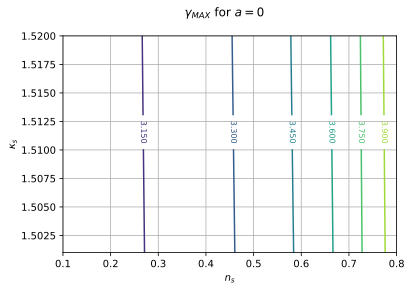

In [130]:
kappa_s_grid,n_s_grid=np.meshgrid(kappa_s_list,n_s_list)
c = plt.contour(n_s_grid,kappa_s_grid,b_min_mat)
plt.clabel(c,inline=True,fontsize=8)
plt.suptitle(r'$\gamma_{MAX}$' + r' for $a=$'+str(a))
plt.xlabel('$n_s$')
plt.ylabel('$\kappa_s$')
plt.grid()
plt.show()